# Initialization through BNSE for SM kernel

Comparison between initializing sm kernel with different heuristics

* Random (See Andrew Wilson PHD thesis)
* Lomb Scargle
* BNSE

In [1]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext autoreload
%autoreload 2

sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
def experiment(x_train, y_train, x_test, y_test, true_means, Q=3, n_trials=100):
    """
    Experiment with the 3 initializations for GP-SM
    
    The GP is fitted using the data and compared with the real
    parameters. This is done 'n_trial' times for each initialization 
    method.
    """
    # total error
    mae_param = np.zeros((3, n_trials))
    mae_pred = np.zeros((3, n_trials))
    
    x_test = [x_test.reshape(-1, 1)]
    
    # create and train model
    data = mogptk.Data(x_train, y_train)
    
    init_methods = ['random', 'LS', 'BNSE']
    
    for i, method in enumerate(init_methods):
        for n in range(n_trials):
            # pick random seed
            seed = np.random.randint(1, int(1e8))
            np.random.seed(seed)
            
            model = mogptk.SM([data], Q=Q)
            model.init_params(method)
            model.train(maxiter=5000)
            
            # param error
            means_pred = get_param_across(model, 'mixture_means').reshape(-1)
            mae_param[i, n] = np.abs(true_means - means_pred).sum()
            
            # pred error
            y_pred, var_pred = model.predict(x_test)
            mae_pred[i, n] = np.abs(y_test - y_pred[0]).mean()
            
    return mae_param, mae_pred

Create data for the experiment

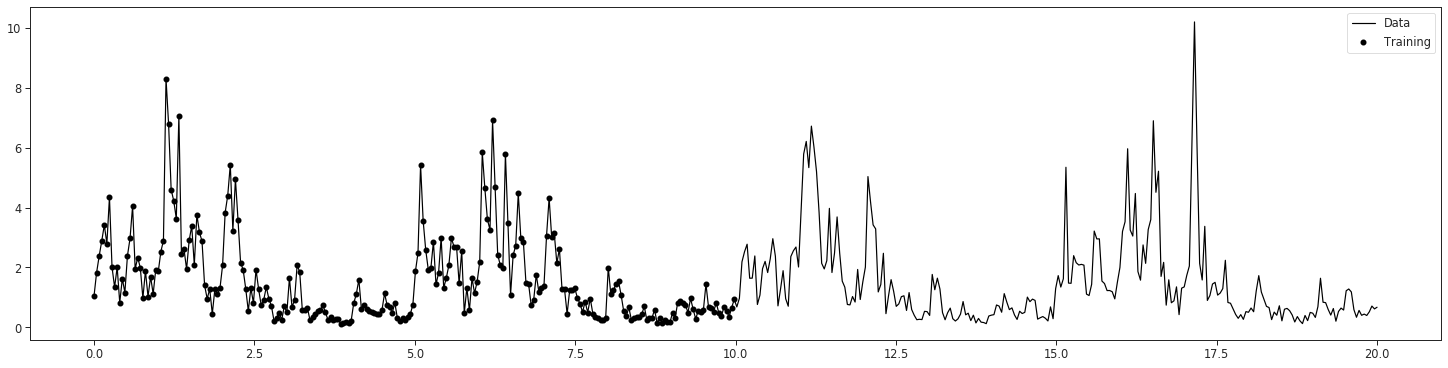

In [3]:
# target freq to estimate
target_freqs = np.array([0.2, 1, 2])
target_amps = [1, 0.5, 0.5]

n_points = 500

t = np.linspace(0, 20, n_points)
y = np.zeros(n_points)

for i in range(3):
    y += target_amps[i] * np.sin(2 * np.pi * target_freqs[i] * t)
    
y_n = y + np.random.normal(scale=0.4, size=n_points)
y_n = np.exp(y_n)
y_n += -y_n.min() + 1e-1

# data class
data = mogptk.Data(t.reshape(-1, 1), y_n)
data.remove_range(start=10.0, end=None)

data.plot()

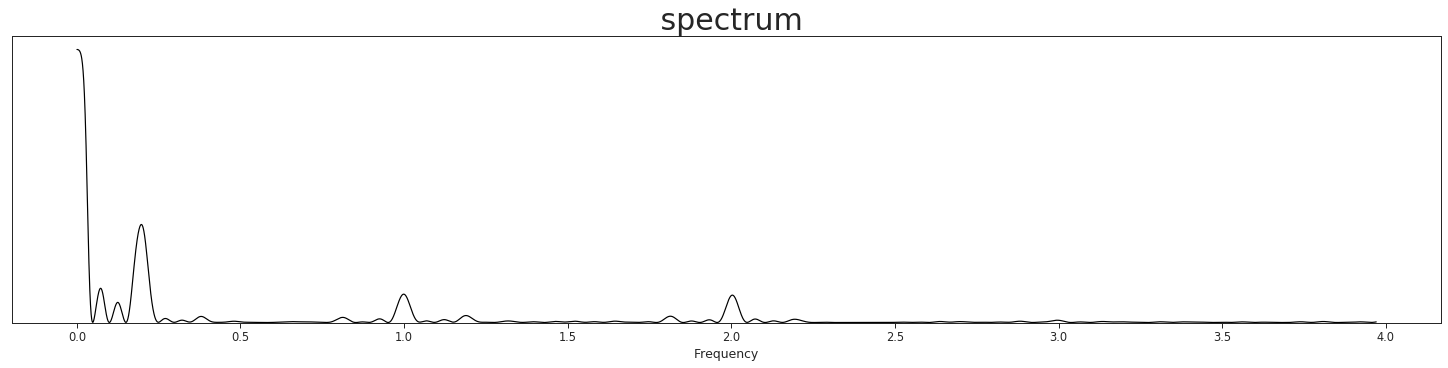

In [4]:
data.plot_spectrum()

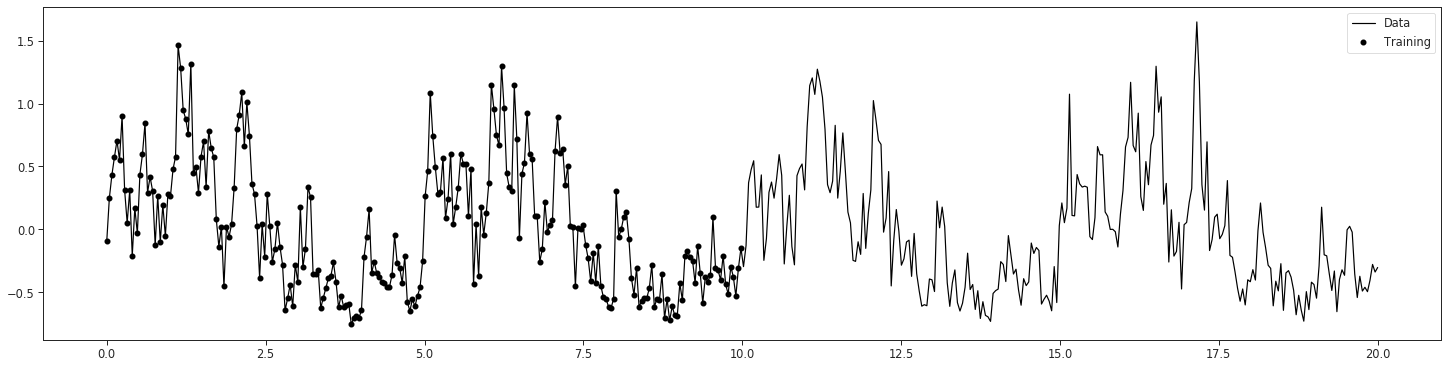

In [5]:
data.transform(mogptk.TransformLog)
data.plot()

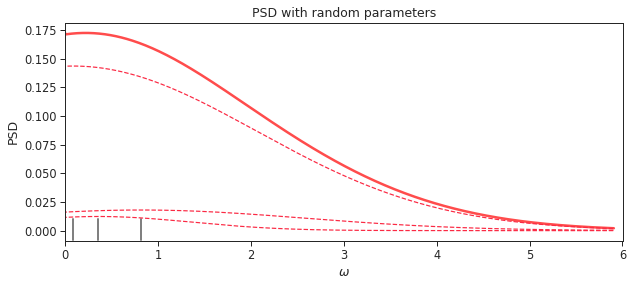

In [6]:
# create model
model = mogptk.SM([data], Q=3)

model.plot_psd(title='PSD with random parameters')

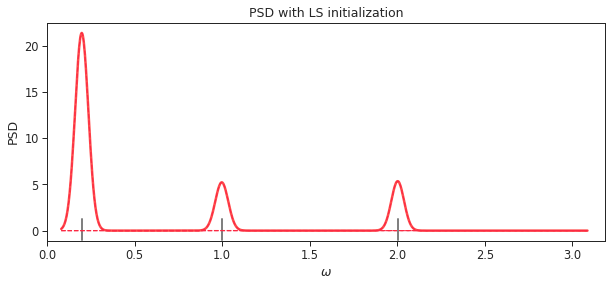

In [7]:
seed = np.random.randint(1, int(1e8))
np.random.seed(seed)

# initialize params
method = 'LS'
model.init_params(method=method)

model.plot_psd(title='PSD with {} initialization'.format(method))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -16.649736
  Number of iterations: 65
  Number of functions evaluations: 81
Done in  0.018639771143595378  minutes


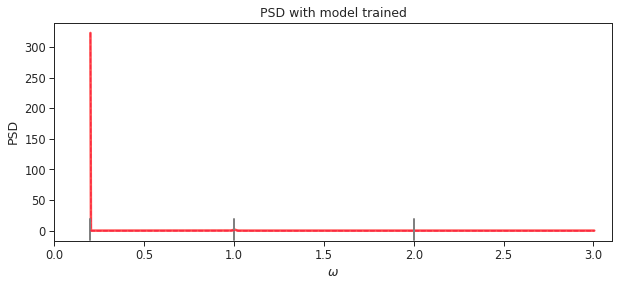

In [8]:
model.build()

model.train(method='L-BFGS-B', maxiter=5000)

model.plot_psd(title='PSD with model trained')

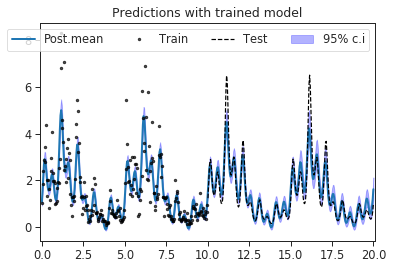

In [9]:
x_pred = [t.reshape(-1, 1)]
y_pred, lower_ci, upper_ci  = model.predict(x_pred)

plt.plot(x_pred[0], y_pred[0], label='Post.mean', lw=2, zorder=2)
plt.plot(t[:250], y_n[:250], '.k', alpha=0.7, zorder=2, label='Train')
plt.plot(t[250:], np.exp(y[250:]), '--k', zorder=3, label='Test')
plt.fill_between(x_pred[0].reshape(-1),
                 lower_ci[0],
                 upper_ci[0],
                 color='b',
                 alpha=0.3,
                 zorder=1,
                 label='95% c.i')
plt.xlim(-0.1, 20.1)
plt.legend(ncol=4)
plt.title('Predictions with trained model');

In [10]:
# err_param, err_pred = experiment(t[:250], y_n[:250], t, y, target_freqs, Q=3, n_trials=10)

In [11]:
# err_param.mean(1), err_param.std(1)

In [12]:
# err_pred.mean(1), err_pred.std(1)


# Experiment 1: Mauna Loa

In [13]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

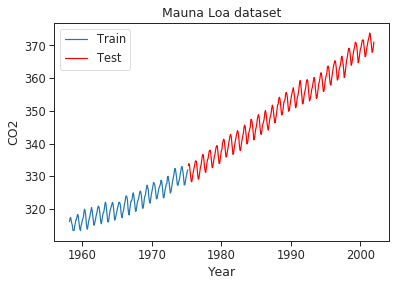

In [14]:
x, y = load_mauna_loa_atmospheric_co2()

stop = 200

plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2');
plt.title('Mauna Loa dataset');

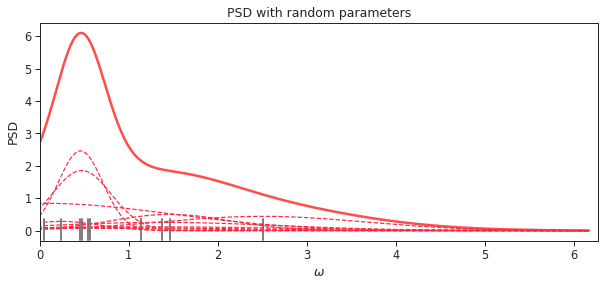

In [15]:
# add data
data = mogptk.Data(x[:stop, np.newaxis], y[:stop])
data.transform(mogptk.TransformDetrend)

# create model
model = mogptk.SM([data], Q=10)

model.plot_psd(title='PSD with random parameters')

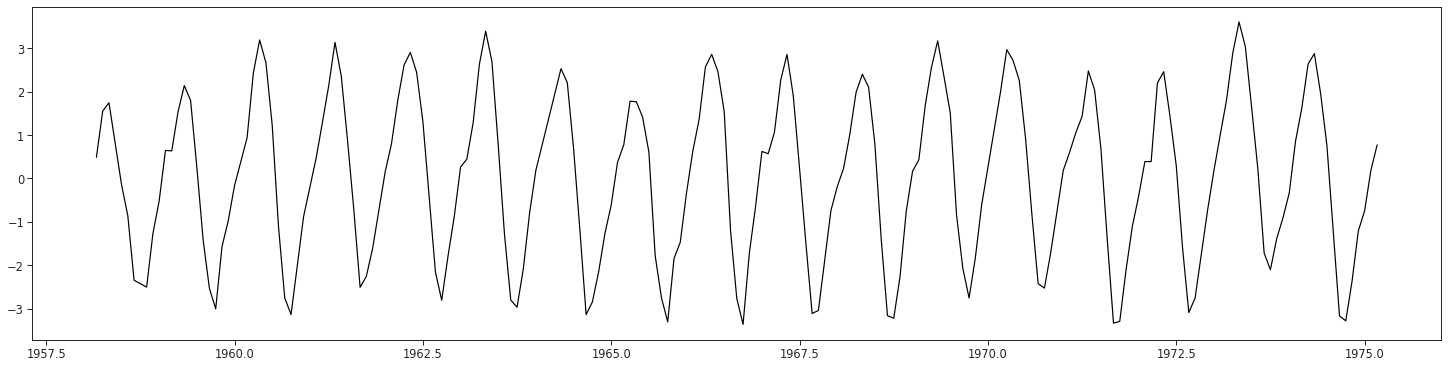

In [16]:
# plot detrended data
data.plot()

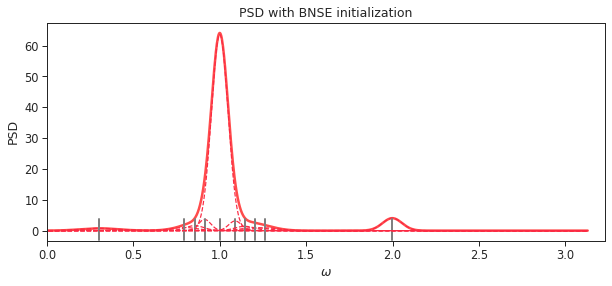

In [17]:
method = 'BNSE'
model.init_params(method)
model.plot_psd(title='PSD with {} initialization'.format(method))

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 65.757330
  Number of iterations: 10000
  Number of functions evaluations: 11364
Done in  0.7675166805585225  minutes
CPU times: user 47.6 s, sys: 7.84 s, total: 55.4 s
Wall time: 46.2 s


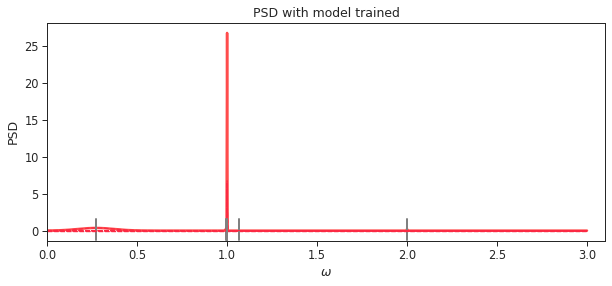

In [18]:
%%time 
model.build()
model.train(method='L-BFGS-B', maxiter=10000, tol=1e-85)

model.plot_psd(title='PSD with model trained')

CPU times: user 276 ms, sys: 4 ms, total: 280 ms
Wall time: 277 ms


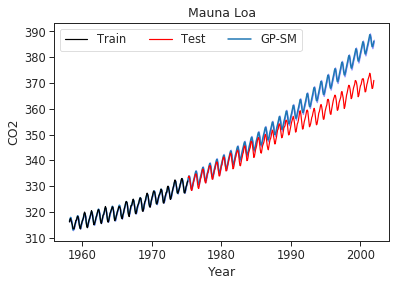

In [19]:
%%time 
# prediction
x_pred = [x.reshape(-1, 1)]

y_pred, lower_ci, upper_ci = model.predict(x_pred)

# plot
plt.plot(x[:stop], y[:stop], '-k', label='Train')
plt.plot(x[stop:], y[stop:], '-r', label='Test')
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 lower_ci[0],
                 upper_ci[0],
                 color='b',
                 alpha=0.3,
                 zorder=1)
plt.legend(ncol=3)
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')

In [20]:
# true_means = np.zeros(model.Q)
# err_param, err_pred = experiment(x[:stop], y[:stop], x, y, true_means, Q=model.Q, n_trials=20)

In [21]:
# err_pred.mean(1), err_pred.std(1)

# Airplane passangers

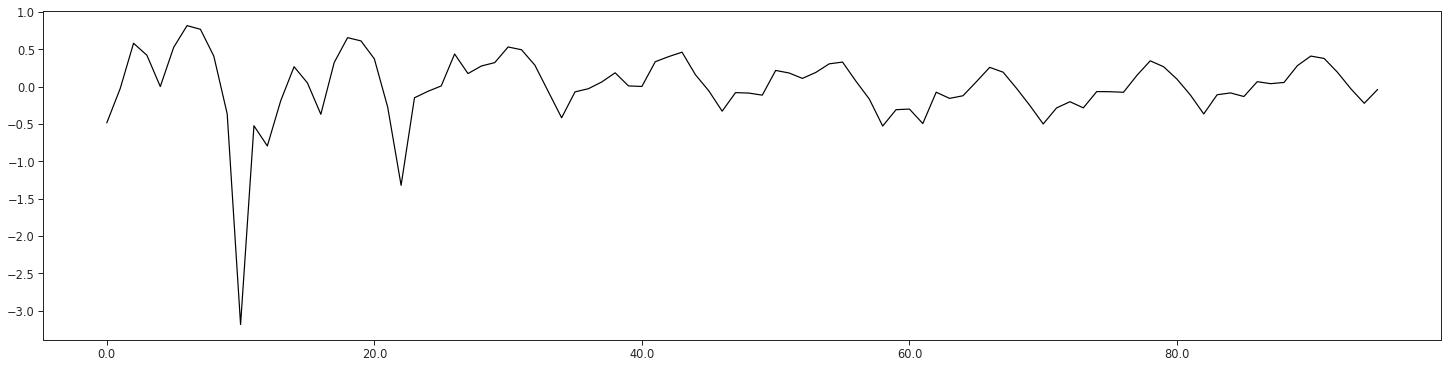

In [22]:
air = np.loadtxt('data/Airline_passenger.csv')

stop = 96

x = air[: ,0]
y = air[:, 1]

# add data
data = mogptk.Data(x[:stop, np.newaxis], y[:stop])

data.transform(mogptk.TransformLog)
data.transform(mogptk.TransformDetrend)

# create model
model = mogptk.SM([data], Q=5)

data.plot()

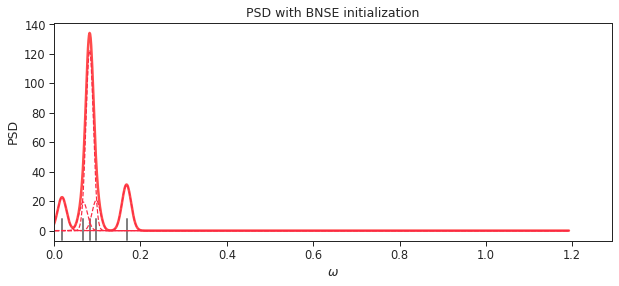

In [23]:
method = 'BNSE'
model.init_params(method)

model.plot_psd(title='PSD with {} initialization'.format(method))

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 31.747992
  Number of iterations: 540
  Number of functions evaluations: 641
Done in  0.026932811737060545  minutes


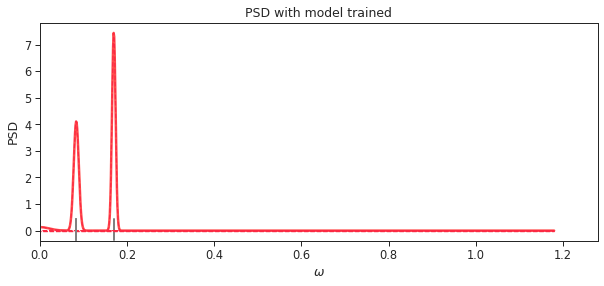

In [24]:
model.build()
model.train('L-BFGS-B', maxiter=2000, tol=1e-80)

model.plot_psd(title='PSD with model trained')

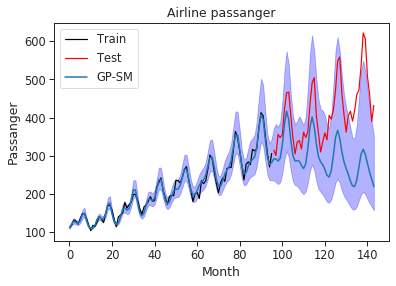

In [25]:
x_pred = [x[:, np.newaxis]]
y_pred, lower_ci, upper_ci = model.predict(x_pred)

# plot
plt.plot(x[:stop], y[:stop], '-k', label='Train')
plt.plot(x[stop:], y[stop:], '-r', label='Test')
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=2, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 lower_ci[0],
                 upper_ci[0],
                 color='b',
                 alpha=0.3,
                 zorder=1)
plt.title('Airline passanger')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Passanger');

# Jura single output


Save for later (until multi input)